Useful links

- https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
- https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677
- https://towardsdatascience.com/time-series-forecasting-with-rnns-ff22683bbbb0
- https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
- https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621
- http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/
- https://colah.github.io/posts/2015-09-NN-Types-FP/
- https://pytorch.org/docs/stable/nn.html#rnn

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import traceback as tb
import torch

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

### Download India's data

In [2]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(np.int64(d['dailyconfirmed']))
        r['deceased'].append(np.int64(d['dailydeceased']))
        r['recovered'].append(np.int64(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)
df.sample()

,date,confirmed,deceased,recovered
33,2020-03-03,1,0,0


### Italy's and Spain's data

In [3]:
it_df = pd.read_csv('csv/italy.csv')
print(it_df.sample())

es_df = pd.read_csv('csv/spain.csv')
print(es_df.sample())

          date  deceased  recovered  confirmed  active  daily
19  2020-03-11       827     1045.0      12462   10590   2313
          date   deaths  recovered  confirmed  active  daily
38  2020-04-02  10384.0      26540     126337   89413   7241


### Prep data

In [20]:
def get_rnn_dataset(series, seq_len):
    """get rnn training dataset, given a series and seq_len"""
    ip_seq = np.array(series[:-1], dtype=np.float32)
    op_seq = np.array(series[1:], dtype=np.float32)
    data_len = len(series) - 1

    ips = []
    ops = []
    for i in range(data_len - seq_len + 1):
        ip, op = ip_seq[i : i+seq_len], op_seq[i : i+seq_len]
        ips.append(ip)
        ops.append(op)
    ips = np.array(ips, dtype=np.float32)
    ops = np.array(ops, dtype=np.float32)

    # convert from numpy to torch
    ip_t = torch.from_numpy(ips)
    op_t = torch.from_numpy(ops)

    dataset = tdt.TensorDataset(ip_t, op_t)
    return dataset

# preprocess data: sma(6) and normalise by 10k
in_cnf = np.array(df['confirmed'][37:].rolling(6, center=True, min_periods=1).mean()) / 10000
it_cnf = np.array(it_df['daily'].rolling(6, center=True, min_periods=1).mean()) / 10000
es_cnf = np.array(es_df['daily'].rolling(6, center=True, min_periods=1).mean()) / 10000

# Choose among India or Italy or Spain here
cnf = np.append(it_cnf, es_cnf)
SEQ_LEN = 5
dataset = get_rnn_dataset(cnf, SEQ_LEN)

seq_data_loader = tdt.DataLoader(dataset, shuffle=False, batch_size=1)
rnd_data_loader = tdt.DataLoader(dataset, shuffle=True, batch_size=1)

### Define NN and train

Epoch: 0 Iter:  0 Loss:  0.51201 Out: -6623.62 Ex:  584.67
Epoch: 0 Iter: 10 Loss:  0.03202 Out:  7002.86 Ex:  6693.50
Epoch: 0 Iter: 20 Loss:  0.06360 Out:  5555.92 Ex:  3659.67
Epoch: 0 Iter: 30 Loss:  0.00179 Out:  960.13 Ex:  1133.50
Epoch: 0 Iter: 40 Loss:  0.00119 Out:  6901.93 Ex:  7098.00
Epoch: 0 Iter: 50 Loss:  0.00817 Out: -466.90 Ex:  406.50
Epoch: 0 Iter: 60 Loss:  0.00273 Out:  229.19 Ex:  10.80
Epoch: 0 Iter: 70 Loss:  0.00046 Out:  3221.56 Ex:  3433.33
Epoch: 0 Iter: 80 Loss:  0.00101 Out:  1725.83 Ex:  1962.83
Epoch: 0 Iter: 90 Loss:  0.00146 Out:  420.79 Ex:  754.75
Epoch: 0 Iter: 100 Loss:  0.00203 Out:  6006.64 Ex:  5486.67
Epoch: 0 Iter: 110 Loss:  0.00024 Out:  1446.51 Ex:  1570.33
Epoch: 0 Iter: 120 Loss:  0.00044 Out:  3927.41 Ex:  3844.33
Epoch: 0 Iter: 130 Loss:  0.00031 Out:  5607.79 Ex:  5555.67
Epoch: 0 Iter: 140 Loss:  0.00719 Out:  5385.33 Ex:  5994.83
Epoch: 0 Iter: 150 Loss:  0.00064 Out:  3003.01 Ex:  3242.67
Epoch: 0 Iter: 160 Loss:  0.00257 Out:  199

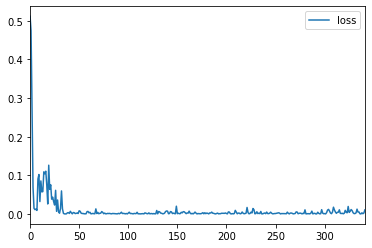

In [21]:
class Forecaster(tnn.Module):
    def __init__(self, seq_len=1, hidden_size=1):
        super(Forecaster, self).__init__()
        
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        
        self.rnn = tnn.RNN(input_size=1, hidden_size=hidden_size)
    
    def forward(self, ip):
        outs, h = self.rnn(ip)
        return outs.view(self.seq_len)
    
    def predict(self, ip, num_predictions=1):
        preds = []
        with torch.no_grad():
            pred = ip
            while(num_predictions):
                pred = self.forward(pred.view(self.seq_len, 1, 1))
                preds.append(pred.view(self.seq_len)[-1].item())
                num_predictions-=1
        return torch.tensor(np.array(preds, dtype=np.float32))

model = Forecaster(seq_len=SEQ_LEN, hidden_size=1)
loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=0.1)

# TRAIN
loss_vals = []
pred_vals = []

num_epochs = 2
for e in range(num_epochs):
    for i, data in enumerate(rnd_data_loader):
        ip, op = data

        # set grads to 0
        optimizer.zero_grad()

        # predict
        pred = model(ip.view(SEQ_LEN, 1, 1))

        # calc loss
        loss = loss_fn(pred, op.view(SEQ_LEN))

        # logging
        loss_vals.append(loss.item())
        if i%10 == 0:
            print("Epoch:", e, "Iter:", f"{i:2}", "Loss:", f"{loss.item(): .5f}", "Out:", f"{pred.view(SEQ_LEN)[-1].item()*10000: .2f}", "Ex:", f"{op.view(SEQ_LEN)[-1].item()*10000: .2f}")

        # assign grads
        loss.backward()

        # update weights
        optimizer.step()

df_loss = pd.DataFrame({
    'loss': loss_vals
})
df_loss.plot(
    y='loss'
)

### Test
- future values on any country's data

IN: tensor([4332.6665, 4737.3335, 4996.6665, 5234.3999, 5344.5000])
OUT: tensor([5707.6655, 5991.3433, 6205.2920, 6362.8101, 6477.2158])


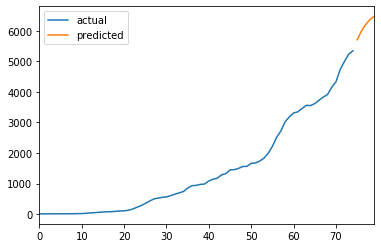

In [37]:
# CHOOSE FROM IN, IT OR ES HERE
df_cnf = in_cnf
# df_cnf = np.array([8000, 7600, 7300, 6900, 6650], dtype=np.float32) / 10000

test_in = df_cnf[-SEQ_LEN:]
t = torch.tensor(
    test_in.reshape(SEQ_LEN, 1, 1),
    dtype=torch.float32
)
print("IN:", t.view(SEQ_LEN) * 10000)
out = model.predict(t, num_predictions=5)
print("OUT:", out * 10000)

orig_df = pd.DataFrame({
    'actual': df_cnf * 10000
})
fut_df = pd.DataFrame({
    'predicted': (out.numpy() * 10000)
})
orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)
_ = orig_df.plot()

- on training data

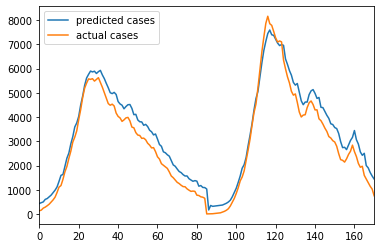

In [24]:
pred_vals = []
out_vals = []
for data in seq_data_loader:
    ip, op = data
    pred = model.predict(ip.view(SEQ_LEN, 1, 1))
    pred_vals.append(pred.item() * 10000)
    out_vals.append(op.view(SEQ_LEN)[-1].item() * 10000)

cmp_df = pd.DataFrame({
    'predicted cases': pred_vals,
    'actual cases': out_vals
})
_ = cmp_df.plot()

In [27]:
for k in model.state_dict().keys():
    print(k, "=", model.state_dict()[k])

rnn.weight_ih_l0 = tensor([[1.3649]])
rnn.weight_hh_l0 = tensor([[-0.2106]])
rnn.bias_ih_l0 = tensor([0.4601])
rnn.bias_hh_l0 = tensor([-0.4223])
